# CNN (Convolutional Neural Networks) による画像の分類

Based on https://www.kaggle.com/toregil/welcome-to-deep-learning-cnn-99

If you want to apply machine learning to image recognition, convolutional neural networks (CNN) is the way to go. It has been sweeping the board in competitions for the last several years, but perhaps its first big success came in the late 90's when [Yann LeCun][1] used it to solve MNIST with 99.5% accuracy. I will show you how it is done in Keras, which is a user-friendly neural network library for python.

Many other notebooks here use a simple fully-connected network (no convolution) to achieve 96-97%, which is a poor result on this dataset. In contrast, what I will show you here is nearly state-of-the-art. In the Kernel (<20 minutes training) we will achieve 99%, but if you train it overnight (or with a GPU) you should reach 99.5. If you then ensemble over several runs, you should get close to the best published accuracy of 99.77% . (Ignore the 100% results on the leaderboard; they were created by learning the test set through repeat submissions)

Here goes:


  [1]: http://yann.lecun.com/exdb/lenet/

## Library の読み込み

In [1]:
import numpy as np # linear algebra
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [2]:
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler

Using TensorFlow backend.


In [4]:
import tensorflow as tf
print(tf.__version__)

2.1.0


ファイル関連定数

In [5]:
train_file = "./data/train.csv"
test_file = "./data/test.csv"
output_file = "cnn_keras_1.csv"

## データの読み込みと前処理

NumPyを使ってCSVファイルを読み込みます。（Pandasでもできますが、今回はNumpyの行列でデータを扱うので Numpy に統一しました）

In [6]:
raw_data = np.loadtxt(train_file, skiprows=1, dtype='int', delimiter=',')
x_train, x_val, y_train, y_val = train_test_split(
    raw_data[:,1:], raw_data[:,0], test_size=0.1)

In [7]:
x_train

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [8]:
x_train[100]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,  72, 219, 252, 172, 255, 195,
       115,  22,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0, 120, 253, 25

Each data point consists of 784 values. A fully connected net just treats all these values the same, but a CNN treats it as a 28x28 square. Thes two graphs explain the difference: It's easy to understand why a CNN can get better results.

Text(0.5, 1.0, '28x28 data')

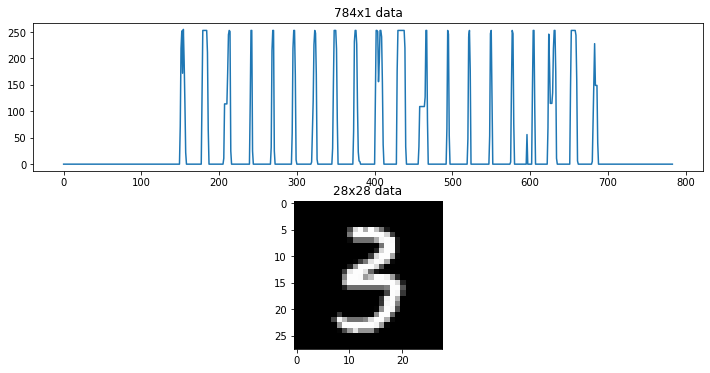

In [9]:
fig, ax = plt.subplots(2, 1, figsize=(12,6))
ax[0].plot(x_train[100])
ax[0].set_title('784x1 data')
ax[1].imshow(x_train[100].reshape(28,28), cmap='gray')
ax[1].set_title('28x28 data')

We now reshape all data this way. Keras wants an extra dimension in the end, for channels. If this had been RGB images, there would have been 3 channels, but as MNIST is gray scale it only uses one.

This notebook is written for the tensorflow channel ordering. If you have Keras installed for Theano backend, you might start seeing some error message soon related to channel ordering. This can easily be [solved][1].


  [1]: https://keras.io/backend/#set_image_dim_ordering

Keras requires an extra dimension in the end which correspond to channels. MNIST images are gray scaled so it use only one channel. For RGB images, there is 3 channels, we would have reshaped 784px vectors to 28x28x3 3D matrices.

In [10]:
# データを一次元配列に変換
x_train = x_train.reshape(-1, 28, 28, 1)
x_val = x_val.reshape(-1, 28, 28, 1)

In [11]:
x_train

array([[[[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        ...,

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]]],


       [[[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]],

        ...,

        [[0],
         [0],
         [0],
         ...,
         [0],


In [12]:
x_train[100]

array([[[  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0]],

       [[  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0]],

       [[  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
      

In [13]:
# 1次元配列に変換
x_train[100][:,:,0]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  72, 219, 252,
        172, 255, 195, 115,  22,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  

最初の４０個のデータを白黒画像で表示

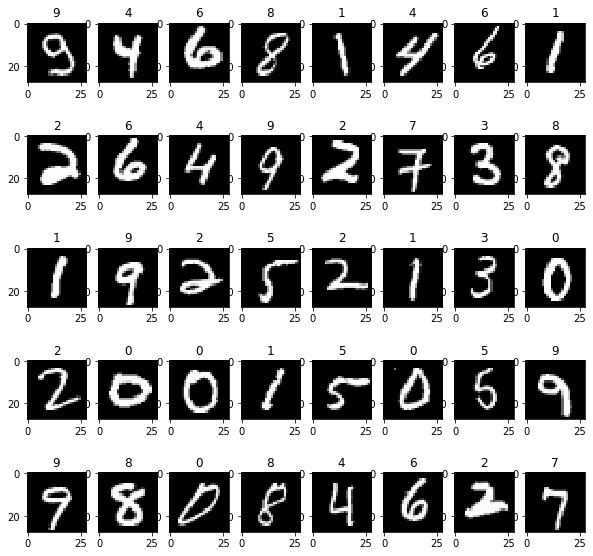

In [14]:
labels = ["0","1","2","3","4","5","6","7","8","9"]

plt.figure(figsize=(10, 10))
for i in range(0, 40):
    im = x_train[i][:,:,0]
    plt.subplot(5, 8, i + 1)
    plt.title(labels[y_train[i]])
    plt.tick_params(labelbottom="off",bottom="off") # x軸をオフ
    plt.tick_params(labelleft="off",left="off") # y軸をオフ
    plt.imshow(im, cmap='gray')

plt.show()

It would be possible to train the net on the original data, with pixel values 0 to 255. If we use the standard initialization methods for weights, however, data between 0 and 1 should make the net converge faster. 

In [15]:
# 値域の変換 [0-255] -> [0.0-1.0]
x_train = x_train.astype("float32")/255.
x_val = x_val.astype("float32")/255.

The labels were given as integers between 0 and 9. We need to convert these to one-hot encoding, i.e. a 10x1 array with one 1 and nine 0:s, with the position of the 1 showing us the value. See the example, with the position of the 1 showing the correct value for the digit in the graph above.

In [16]:
# ラベルデータをOne-Hot形式に変換
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)

[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


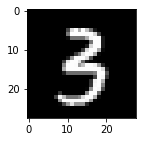

In [17]:
#example:
print(y_train[100])
fig, ax = plt.subplots(1, 1, figsize=(2,2))
plt.imshow(x_train[100][:,:,0], cmap='gray')

## モデルの作成と学習

Keras offers two different ways of defining a network. We will the Sequential API, where you just add on one layer at a time, starting from the input.

The most important part are the convolutional layers Conv2D. Here they have 16-32 filters that use nine weights each to transform a pixel to a weighted average of itself and its eight neighbors. As the same nine weights are used over the whole image, the net will pick up features that are useful everywhere. As it is only nine weights, we can stack many convolutional layers on top of each other without running out of memory/time. 

The MaxPooling layers just look at four neighboring pixels and picks the maximal value. This reduces the size of the image by half, and by combining convolutional and pooling layers, the net be able to combine its features to learn more global features of the image. In the end we use the features in two fully-connected (Dense) layers.

Batch Normalization is a technical trick to make training faster. Dropout is a regularization method, where the layer randomly replaces  a proportion of its weights to zero for each training sample. This forces the net to learn features in a distributed way, not relying to much on a particular weight, and therefore improves generalization. 'relu' is the activation function x -> max(x,0).

In [18]:
model = Sequential()

model.add(Conv2D(filters = 16, kernel_size = (3, 3), activation='relu',
                 input_shape = (28, 28, 1)))
model.add(BatchNormalization())
model.add(Conv2D(filters = 16, kernel_size = (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters = 16, kernel_size = (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(strides=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(strides=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

In [19]:
# 学習の前に、モデル構造を確認
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 16)        160       
_________________________________________________________________
batch_normalization_1 (Batch (None, 26, 26, 16)        64        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 16)        2320      
_________________________________________________________________
batch_normalization_2 (Batch (None, 24, 24, 16)        64        
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 22, 22, 16)        2320      
_________________________________________________________________
batch_normalization_3 (Batch (None, 22, 22, 16)        64        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 11, 11, 16)       

The model needs to be compiled before training can start. As our loss function, we use logloss which is called ''categorical_crossentropy" in Keras. Metrics is only used for evaluation. As optimizer, we could have used ordinary stochastic gradient descent (SGD), but Adam is faster.

In [20]:
model.compile(loss='categorical_crossentropy', optimizer = Adam(lr=1e-4), metrics=["accuracy"])

In [21]:
hist = model.fit(x_train, y_train, 
                 validation_data=(x_val, y_val), 
                 batch_size=16, 
                 verbose=1,  # 0 = 表示なし，1 = プログレスバー，2 = 各試行毎に一行の出力．
                 epochs=3)

# モデルを保存
model.save_weights('cnn_keras_1.hdf5')

Train on 37800 samples, validate on 4200 samples
Epoch 1/3
37800/37800 [==============================] - 488s 13ms/step - loss: 0.6197 - accuracy: 0.7963 - val_loss: 0.1401 - val_accuracy: 0.9545
Epoch 2/3
37800/37800 [==============================] - 447s 12ms/step - loss: 0.1932 - accuracy: 0.9387 - val_loss: 0.0829 - val_accuracy: 0.9712
Epoch 3/3
37800/37800 [==============================] - 464s 12ms/step - loss: 0.1311 - accuracy: 0.9581 - val_loss: 0.0671 - val_accuracy: 0.9779


## 評価

In [22]:
# 学習済みのモデルを取得
# model.load_weights('cnn_keras_1.hdf5')

In [23]:
# 精度の評価
scores = model.evaluate(x_val, y_val, verbose=1)
print('Validation loss: {0:.4f}'.format(scores[0]))
print('Validation accuracy: {0:.4f}'.format(scores[1]))

4200/4200 [==============================] - 11s 3ms/step
Validation loss: 0.0671
Validation accuracy: 0.9779


In [24]:
# 学習プロセスのプロット用関数

def Learning_Process_Plot(hist):
    acc = hist.history['accuracy'] # tf1.x: acc
    val_acc = hist.history['val_accuracy'] # tf1.x: val_acc
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, label='Training acc', ls="-", marker="o")
    plt.plot(epochs, val_acc, label='Validation acc', ls="-", marker="x")
    plt.title('Training and validation accuracy')
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(loc="best")

    plt.figure()

    plt.plot(epochs, loss, label='Training loss', ls="-", marker="o")
    plt.plot(epochs, val_loss, label='Validation loss', ls="-", marker="x")
    plt.title('Training and validation loss')
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.legend(loc="best")

    plt.show()

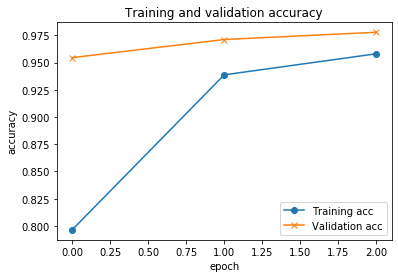

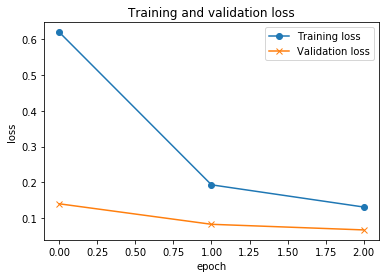

In [25]:
# 学習プロセスのプロット
Learning_Process_Plot(hist)

学習プロセスのプロットにより、MLP の場合と異なり、過学習が起こっていないことが分かる。

In [26]:
y_hat = model.predict(x_val)
y_pred = np.argmax(y_hat, axis=1)
y_true = np.argmax(y_val, axis=1)
cm = confusion_matrix(y_true, y_pred)
print(cm)

[[418   0   0   0   0   0   1   0   2   2]
 [  0 457   3   0   0   0   0   2   0   0]
 [  0   1 415   1   2   0   0   5   1   0]
 [  1   0   3 420   0   1   0   6   0   0]
 [  0   0   0   0 349   0   1   0   0   8]
 [  2   0   0   3   0 411   3   0   1   0]
 [  2   4   0   0   1   1 393   0   0   0]
 [  0   0   2   0   3   0   0 448   1   5]
 [  2   2   0   0   2   1   3   0 389   6]
 [  3   0   0   0   1   2   0   2   1 407]]


In [27]:
from sklearn.metrics import classification_report

labels = ["0","1","2","3","4","5","6","7","8","9"]

# Generate a classification report
report = classification_report(y_pred, y_true, target_names=labels)
print(report)

              precision    recall  f1-score   support

           0       0.99      0.98      0.98       428
           1       0.99      0.98      0.99       464
           2       0.98      0.98      0.98       423
           3       0.97      0.99      0.98       424
           4       0.97      0.97      0.97       358
           5       0.98      0.99      0.98       416
           6       0.98      0.98      0.98       401
           7       0.98      0.97      0.97       463
           8       0.96      0.98      0.97       395
           9       0.98      0.95      0.96       428

    accuracy                           0.98      4200
   macro avg       0.98      0.98      0.98      4200
weighted avg       0.98      0.98      0.98      4200



## Submit

テストデータの読み込み

In [36]:
mnist_testset = np.loadtxt(test_file, skiprows=1, dtype='int', delimiter=',')
x_test = mnist_testset.astype("float32")
x_test = x_test.reshape(-1, 28, 28, 1)/255.

学習したモデルを用いて予測

In [37]:
y_pred = model.predict(x_test, batch_size=64)
y_pred

array([[1.89040517e-15, 3.85093365e-16, 1.00000000e+00, ...,
        1.20592716e-14, 3.48329526e-14, 8.84558203e-19],
       [1.00000000e+00, 2.09138440e-17, 7.57840632e-15, ...,
        3.93767194e-16, 5.47188154e-16, 1.91878752e-11],
       [2.39718823e-09, 9.62882107e-10, 7.36973282e-09, ...,
        4.05529441e-08, 2.99166163e-06, 9.99995351e-01],
       ...,
       [6.29888059e-19, 8.74030693e-16, 7.53828898e-14, ...,
        1.24670483e-13, 2.71862403e-15, 4.19532534e-16],
       [8.62667660e-10, 3.91255611e-10, 7.15424886e-10, ...,
        7.69848896e-08, 3.93032344e-08, 9.99991536e-01],
       [1.10793095e-13, 1.68207750e-14, 1.00000000e+00, ...,
        1.19293193e-12, 5.34641394e-11, 1.70472851e-14]], dtype=float32)

In [38]:
y_pred = np.argmax(y_pred,axis=1) # One-hot データを分類データに変換
y_pred

array([2, 0, 9, ..., 3, 9, 2], dtype=int64)

提出用CSVファイルの作成

In [39]:
with open(output_file, 'w') as f :
    f.write('ImageId,Label\n')
    for i in range(len(y_pred)) :
        f.write("".join([str(i+1),',',str(y_pred[i]),'\n']))